## Neutron count rate as a function of voltage and current

*Erik Hogenbirk, ehogenbi@nikhef.nl, May/June 2016 *

The neutron generator has a control for both current and high voltage, both of with influence the neutron output. To measure this dependence, we try several voltages and currents and calculate the relative rate.

### Imports

The functions used are mostly tucked away in 'function_definitions.ipynb'. Most of these deal with reading in the data from the files (ASCII files)

In [1]:
%run function_definitions.ipynb
import pylab
from scipy.optimize import curve_fit

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:80% !important; }</style>")

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Data location

In [4]:
'''
Data is found in different files and also different *kinds* of files... unfortunately

2016_MAY_25_3.MS #10, #11, #18
2016_MAY_27_1.MS #2                50kV    1 mA
2016_MAY_27_1.MS #3                50kV    .7mA
2016_MAY_30_2_5MeV_LC1_FG_2.mpa    56kV    2.2mA
2016_MAY_30_2_5MeV_LC1_FG_3.mpa    54kV?   1 mA
2016_JUN_01_2_5MeV_NE213_FG_2.mpa 40kV    1 mA
2016_JUN_02_2_5MeV_NE213_FG_2.mpa 40kV    .5 mA
''';

In [5]:
background_filenames = [
    './PTB_DATA/2016_MAY_10/2016_MAY_10_0KeV_LC1_FG_1.MPA',
    './PTB_DATA/2016_MAY_13/2016_MAY_13_0KeV_LC1_FG_1.MPA'
    
]

In [6]:
count_file = './PTB_DATA/2016_MAY_27/2016_MAY_27_1.MSa'
ang_scan_file = './PTB_DATA/2016_MAY_25/2016_MAY_25_3.MSa'

In [7]:
mpa_filenames = [
    './PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_2.MPA',
    './PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_3.MPA',
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_2.mpa',
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_2.mpa',
    './PTB_DATA/2016_JUN_03/2016_JUN_03_2_5MeV_NE213_FG_1.mpa',
    './PTB_DATA/2016_JUN_03/2016_JUN_03_2_5MeV_NE213_FG_2.mpa',
    './PTB_DATA/2016_JUN_03/2016_JUN_03_2_5MeV_NE213_FG_3.mpa'
]

In [8]:
sc_filenames = [
    'PTB_DATA/Run01_160525.txt',
    'PTB_DATA/Run02_160527.txt',
    'PTB_DATA/Run03_160531.txt',
]

### Read SC data

We want an effective value for current and voltage, which we get from slow control data. The SC program stores voltage and current with a one-second resolution and stores it into an ASCII file.

In [9]:
t_list = []
sc_data_list = []
for fn in sc_filenames:
    t, sc_data = read_sc_data(fn)
    t_list.append(t)
    sc_data_list.append(sc_data)
t = np.concatenate(t_list)
sc_data = np.concatenate(sc_data_list)

### Get BG rate

The long counter that we used has a finite background rate from neutron background. It was measured before we came to PTB. We'll correct for this by subtracting background rate.

In [10]:
bg_counts = 0
bg_livetime = 0.
bg_rate = 0.

for fn in background_filenames:
    d = get_mpa_data(fn)
    bg_counts += d['lc_counts']
    bg_livetime += d['livetime']
bg_rate = bg_counts/bg_livetime
print("Neutron background rate: %d in %.2f days, or %.5f Hz (one every %.1f seconds)" % (bg_counts, bg_livetime / 86400, bg_rate, 1/bg_rate))

scrtime=493953.31

sc#05=14704 	; Geiger Muller (GM)

sc#07=4386 	; #07

livetime=493944.641  

scrtstart=1462373047.609	; 05/04/2016 16:44:07

scrtstart=1462373047.609	; 05/04/2016 16:44:07

scrtime=264472.38

sc#05=7773 	; Geiger Muller (GM)

sc#07=2457 	; #07

livetime=264467.839  

scrtstart=1462955391.906	; 05/11/2016 10:29:51

scrtstart=1462955391.906	; 05/11/2016 10:29:51

Neutron background rate: 6843 in 8.78 days, or 0.00902 Hz (one every 110.8 seconds)


### Read count data

In [11]:
# This will hold count data
# In case you dispute this it IS holy data. Just a few numbers but still weeks of work...
# contains the following: [voltage, current, rate, corrected rate, error on rate, livetime]
holy_data = []

In [12]:
# This is really dirty code to combine 3 datasets at same settings.
# Hope to replace with new measurement soon...
d = read_msa_data(ang_scan_file, verbose=False)
d = d[[10-1,11-1,18-1]]

v_sum = 0.
interval_sum = 0.
i_sum = 0.
lc_counts_sum = 0

for meas in d:
    v, i, dt = get_correction_factor(t,sc_data,meas['start'],meas['end'],verbose=False, plot=False)
    v_sum += v**3.5
    i_sum += i
    interval_sum += meas['interval'] 
    lc_counts_sum += meas['lc_counts']
    
v = ((v_sum/len(d))**(1/3.5))
i = ((i_sum/len(d))**(1/1.))
lc_rate = lc_counts_sum / interval_sum
lc_rate_err = np.sqrt(lc_counts_sum) / lc_counts_sum * lc_rate
holy_data.append([np.array([v, i, lc_rate, lc_rate - bg_rate, lc_rate_err, interval_sum])])
#print([v, i, lc_rate, lc_rate - bg_rate, lc_rate_err])

In [13]:
# first the data in msa files
d = read_msa_data(count_file, verbose = False)
d = d[[1,2]]
for meas in d:
    v, i, dt = get_correction_factor(t,sc_data,meas['start'],meas['end'],verbose=False, plot=False)
    meas['interval'] = meas['interval'] - dt
    lc_rate =  meas['lc_counts'] / meas['interval']
    lc_rate_err = np.sqrt(meas['lc_counts'])/meas['lc_counts'] * lc_rate
    holy_data.append([np.array([v, i, lc_rate, lc_rate - bg_rate, lc_rate_err, meas['interval']])])
    #print(v, i, lc_rate, lc_rate - bg_rate, lc_rate_err)

# Now do the mpa files
for fn in mpa_filenames:
    print(fn)
    d = get_mpa_data(fn)
    print(d)
    # v, i, dt = get_correction_factor(t,sc_data,d['start_datetime'],d['end_datetime'],verbose=True, plot=True)
    # STFU mode
    v, i, dt = get_correction_factor(t,sc_data,d['start_datetime'],d['end_datetime'],verbose=True, plot=False)
    d['livetime'] = d['livetime'] - dt
    d['v'] = v
    d['i'] = i
    d['lc_rate'] = d['lc_counts'] / d['livetime']
    d['lc_rate_err'] = np.sqrt(d['lc_counts']) / d['lc_counts'] * d['lc_rate']
    holy_data.append([np.array([d['v'], d['i'], d['lc_rate'], d['lc_rate'] - bg_rate, d['lc_rate_err'], d['livetime']])])
    #print(d['v'], d['i'], d['lc_rate'], d['lc_rate'] - bg_rate, d['lc_rate_err'])

./PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_2.MPA
scrtime=3302.98

sc#05=8768369 	; Geiger Muller (GM)

sc#07=5067 	; #07

livetime=3302.892    

scrtstart=1464629060.296	; 05/30/2016 19:24:20

scrtstart=1464629060.296	; 05/30/2016 19:24:20

{'end_datetime': datetime.datetime(2016, 5, 30, 20, 19, 22, 980000), 'gm_counts': 8768369, 'start_datetime': datetime.datetime(2016, 5, 30, 19, 24, 20), 'livetime': 3302.892, 'start_time_seconds': 1464629060.296, 'lc_counts': 5067, 'runtime': 3302.98}
v_eff: 57.474307
v_avg: 57.473232
v_std: 0.222688

i_eff: 2.189018
i_avg: 2.189018
i_std: 0.004225

deadtime: 0
./PTB_DATA/2016_MAY_30/2016_MAY_30_2_5MeV_LC1_FG_3.MPA
scrtime=5395.33

sc#05=3718782 	; Geiger Muller (GM)

sc#07=3068 	; #07

livetime=5395.210    

scrtstart=1464632500.421	; 05/30/2016 20:21:40

scrtstart=1464632500.421	; 05/30/2016 20:21:40

{'end_datetime': datetime.datetime(2016, 5, 30, 21, 51, 35, 330000), 'gm_counts': 3718782, 'start_datetime': datetime.datetime(2016, 5, 30, 20

In [14]:
holy_data = np.concatenate(holy_data) # [voltage, current, rate, corrected rate, error on rate]
vol = holy_data[:,0]
cur = holy_data[:,1]
rate = holy_data[:,3]
rate_err = holy_data[:,4]
livetimes = holy_data[:,5]

In [15]:
print('Imported data for %d different voltage and current settings.' % len(holy_data))
print('Total livetime: %1f hours' % (sum(livetimes)/3600.))

Imported data for 10 different voltage and current settings.
Total livetime: 42.260001 hours


### Fit data

We try 2 different functions:
  * $f_{\rm fixed} (V, I)    = A_{\rm fixed} * V^{3.5} I^{1} $, which was measured in previous rate measurements at Purdue
  * $f_{\rm floating} (V, I) = A_{\rm floating} * V^{n_1} I^{n_2} $, where we allow different exponential factors from the measured ones at Purdue.\

In [16]:
def f_rate(vi, prefactor, v_power, i_power):
    v, i = vi
    return prefactor*(v**v_power)*i**i_power

p0 = [1E-6, 3.5, 1.]
popt, pcov = curve_fit(f_rate, (vol, cur), rate, p0=p0, sigma=rate_err)

def f_rate_fixed(vi, prefactor):
    v, i = vi
    return prefactor*(v**3.5)*i**1.

p0 = [1E-6]
popt_fixed, pcov_fixed = curve_fit(f_rate_fixed, (vol, cur), rate, p0=p0,  sigma=rate_err)

print('Best-fit exponential factors: V^%.2f x I^%.2f' % (popt[1], popt[2]))

Best-fit exponential factors: V^3.31 x I^1.03


### Plotting settings

In [17]:
v_min = 35
v_max = 60
i_min = 0.4
i_max = 2.5
rate_min = 0.08
rate_max = 2.0
n_gridpoints = 101
log_color = True
x_label = 'Voltage (kV)'
y_label = 'Current (mA)'
point_size = 200
#c_ticks = None #  None is automatic
c_ticks = [0.1, 0.17, 0.3, 0.5, 1, 2]

### Compare data to fit

In [18]:
# Initialize background colors given by fit
xx, yy = pylab.meshgrid(
    pylab.linspace(v_min,v_max, n_gridpoints),
    pylab.linspace(i_min,i_max,n_gridpoints))

zz = pylab.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = f_rate((xx[i,j], yy[i,j]), *popt)
        
zz_fixed = pylab.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz_fixed[i,j] = f_rate_fixed((xx[i,j], yy[i,j]), *popt_fixed)

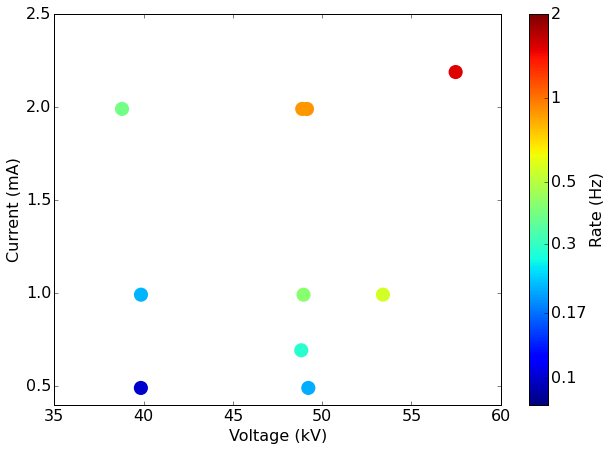

In [19]:
if log_color:
    plt.scatter(vol,cur, c=rate, edgecolors='none', s=point_size, vmin=rate_min, vmax=rate_max, norm=LogNorm())
else:
    plt.scatter(vol,cur, c=rate, edgecolors='none', s=point_size, vmin=rate_min, vmax=rate_max)

cbar = plt.colorbar(label='Rate (Hz)', ticks = c_ticks)
cbar.ax.set_yticklabels(c_ticks)  
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


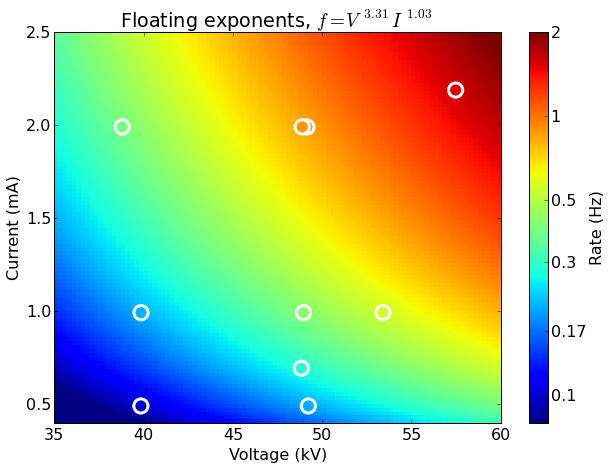

In [36]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.gca()
# Plot fit 
if log_color:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max, norm=LogNorm())
else:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max)

if log_color:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, norm=LogNorm(), linewidth=3)
else:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, linewidth=3)

cbar = plt.colorbar(label='Rate (Hz)', ticks = c_ticks)
cbar.ax.set_yticklabels(c_ticks)   
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Floating exponents, $f = V^{\ \ %.2f}  I^{\ \ %.2f}$ " % (popt[1], popt[2]))
plt.savefig('PTB_rate_UI.png', bbox_inches = 'tight')
plt.savefig('PTB_rate_UI.pdf', bbox_inches = 'tight')

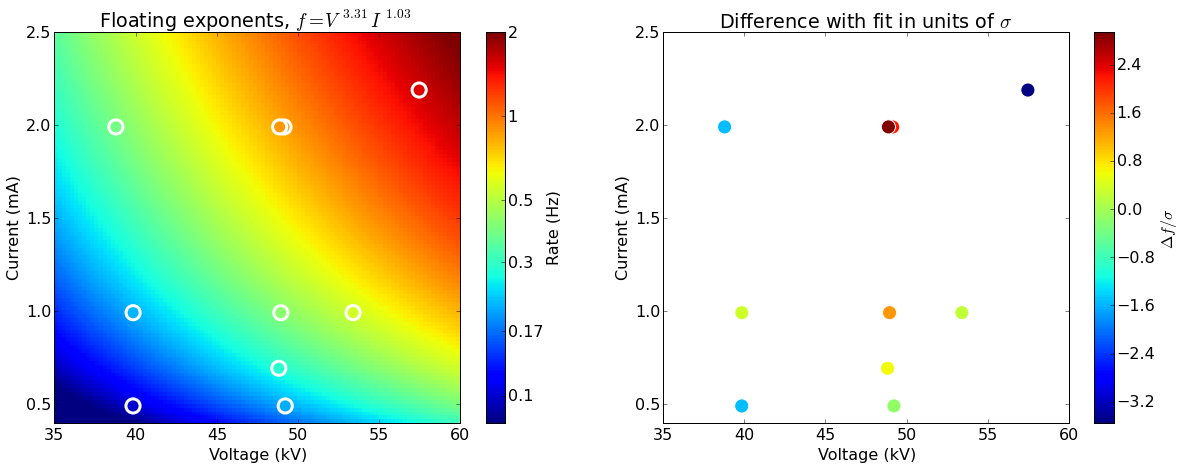

In [20]:
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(1,2,1)
# Plot fit 
if log_color:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max, norm=LogNorm())
else:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max)

if log_color:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, norm=LogNorm(), linewidth=3)
else:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, linewidth=3)

cbar = plt.colorbar(label='Rate (Hz)', ticks = c_ticks)
cbar.ax.set_yticklabels(c_ticks)   
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Floating exponents, $f = V^{\ \ %.2f}  I^{\ \ %.2f}$ " % (popt[1], popt[2]))

ax2 = fig.add_subplot(1,2,2)
# Plot difference with fit
plt.scatter(vol, cur, c = (rate - f_rate((vol, cur), *popt)) / rate_err, edgecolors='white', s=point_size)
cbar = plt.colorbar(label='$\Delta f/\sigma$')
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Difference with fit in units of $\sigma$ " )
plt.show()

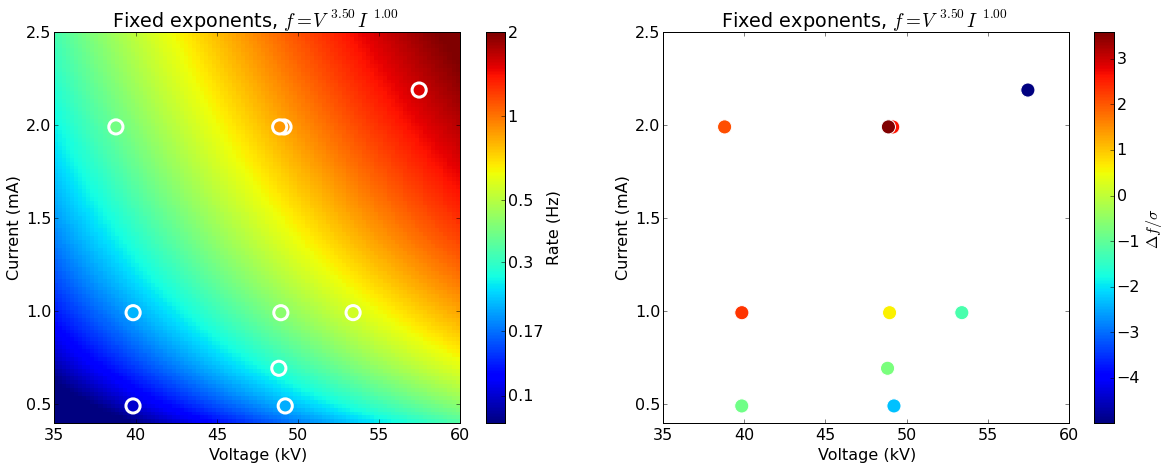

In [21]:
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(1,2,1)
# plot the calculated function values
if log_color:
    pylab.pcolor(xx,yy,zz_fixed, vmin=rate_min, vmax=rate_max, norm=LogNorm())
else:
    pylab.pcolor(xx,yy,zz_fixed, vmin=rate_min, vmax=rate_max)

if log_color:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, norm=LogNorm(), linewidth=3)
else:
    plt.scatter(vol, cur, c = rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, linewidth=3)

cbar = plt.colorbar(label='Rate (Hz)', ticks = c_ticks)
cbar.ax.set_yticklabels(c_ticks)
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Fixed exponents, $f = V^{\ \ 3.50}  I^{\ \ 1.00}$ ")

ax2 = fig.add_subplot(1,2,2)
# Plot difference with fit
plt.scatter(vol, cur, c = (rate - f_rate_fixed((vol, cur), *popt_fixed)) / rate_err, edgecolors='white', s=point_size)
cbar = plt.colorbar(label='$\Delta f/\sigma$')
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Fixed exponents, $f = V^{\ \ 3.50}  I^{\ \ 1.00}$ ")
plt.show()

In [22]:
# 211 (which could also be written in 3-tuple form as (2,1,1) means two rows of plot windows; one column; 
# the third digit specifies the positioning relative to the other subplot windows

### Convert to neutron production rate

In [23]:
'''
E      Eff_c (cm) R_phi (cm^2)
2,15   3,92       3,532
2,2    3,7        3,53
2,5    4,06       3,515
2,7    4,05       3,434
2,814  3,51       3,213
2,815  3,23       2,981
2,816  4,18       3,268
2,83   3,88       3,326
'''

'\nE      Eff_c (cm) R_phi (cm^2)\n2,15   3,92       3,532\n2,2    3,7        3,53\n2,5    4,06       3,515\n2,7    4,05       3,434\n2,814  3,51       3,213\n2,815  3,23       2,981\n2,816  4,18       3,268\n2,83   3,88       3,326\n'

To calculate the flux:
\begin{equation}
\phi = \frac{f}{R_{\phi}}
\end{equation}
with $\phi$ the flux in cm$^{-2}$s$^{-1}$, $f$ the count rate in s$^{-1}$ and $R_{\phi}$ an energy-dependent parameter with units cm$^2$.

In [24]:
d_eff = 150.0 + 4.06 + 7.2 + 13.8/2 # Effective distance: distance outside NG-Cd shield + effective center + distance Cd - reference plane + radius NG
s_eff = 4*np.pi*d_eff**2 # Effective surface area of sphere
phi = rate/3.515 # Flux at 0 degrees and this distance

In [25]:
def gauss(x, A, sigma):
    return A*np.exp(-x**2/(2*sigma**2))
popt_g = np.array([  0.98970953,  50.42659426])
# average over all angles
rate_v_angle_gauss = [gauss(angle, 1., popt_g[1]) for angle in np.linspace(-90,90,200)]
angular_corr = np.average(rate_v_angle_gauss)

In [26]:
n_per_sec = phi * s_eff * angular_corr

In [27]:
n_per_sec

array([ 58932.88069575,  27880.42120252,  18942.10435192,  99879.07001887,
        36650.55795078,  13924.07535134,   6564.94440858,  13493.8416456 ,
        58115.02505707,  25343.48274587])

In [28]:
rate_to_n_per_sec = 1/3.515*angular_corr*s_eff

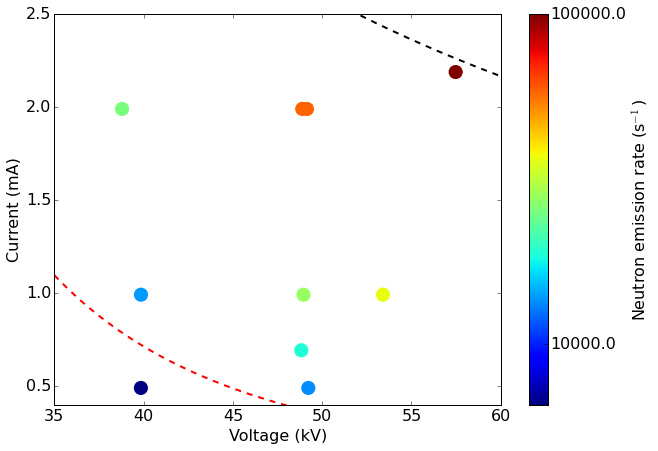

In [29]:
log_color = True

c_ticks_emis = [1e4, 1e5]

if log_color:
    plt.scatter(vol,cur, c=n_per_sec, edgecolors='none', s=point_size, norm=LogNorm())
else:
    plt.scatter(vol,cur, c=n_per_sec, edgecolors='none', s=point_size, vmax=40000)

cbar = plt.colorbar(label='Neutron emission rate (s$^{-1}$)', ticks=c_ticks_emis)
cbar.ax.set_yticklabels(c_ticks_emis)
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)

# Plot function of v
power = 130.
v_fine = np.linspace(v_min, v_max, 200)
plt.plot(v_fine, power/v_fine, ls='--', lw=2, color='black')

plt.plot(v_fine,  
         (10000/(rate_to_n_per_sec * popt[0] * v_fine**(popt[1])))**(1/(popt[2]))
         , ls='--', lw=2, color='red')


plt.show()

In [30]:
rate_to_n_per_sec*rate

array([ 58932.88069575,  27880.42120252,  18942.10435192,  99879.07001887,
        36650.55795078,  13924.07535134,   6564.94440858,  13493.8416456 ,
        58115.02505707,  25343.48274587])

In [31]:
n_per_sec

array([ 58932.88069575,  27880.42120252,  18942.10435192,  99879.07001887,
        36650.55795078,  13924.07535134,   6564.94440858,  13493.8416456 ,
        58115.02505707,  25343.48274587])

In [32]:
rate_to_n_per_sec

65490.722527781138

In [33]:
popt

array([  1.08469153e-06,   3.30763245e+00,   1.02735909e+00])